In [1]:
!pip install transformers

     |████████████████████████████████| 3.1 MB 7.9 MB/s 
     |████████████████████████████████| 61 kB 642 kB/s 
     |████████████████████████████████| 596 kB 72.5 MB/s 
     |████████████████████████████████| 3.3 MB 55.7 MB/s 
     |████████████████████████████████| 895 kB 72.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import numpy as np
import pandas as pd
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
df = pd.read_csv('/content/drive/MyDrive/冒犯/train_combine.csv')

In [4]:

df = df.dropna()

In [5]:
df.head()

,label,content
0,0,hopeless We 're living in times of absolute in...
1,0,"migrant In Libya today , there are countless n..."
2,0,immigrant White House press secretary Sean Spi...
3,0,disabled Council customers only signs would be...
4,0,"refugee "" Just like we received migrants fleei..."


In [6]:
df.label.value_counts()

0    8529
1     947
3     458
4     391
2     144
Name: label, dtype: int64

In [7]:
# 构建 sentences 和 labels 列表
sentences = df.content.values
labels = df.label.values

In [8]:
from transformers import BertTokenizer

# 加载 BERT 分词器
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
print('Done')

Loading BERT tokenizer...


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Done


In [9]:
# 输出原始句子
print(' Original: ', sentences[0])

# 将分词后的内容输出
print('Tokenized: ', tokenizer.encode(sentences[0]))
print('Tokenized: ', tokenizer.encode(sentences[0], add_special_tokens=False)) #默认添加头尾token

 Original:  hopeless We 're living in times of absolute insanity , as I 'm pretty sure most people are aware . For a while , waking up every day to check the news seemed to carry with it the same feeling of panic and dread that action heroes probably face when they 're trying to decide whether to cut the blue or green wire on a ticking bomb -- except the bomb 's instructions long ago burned in a fire and imminent catastrophe seems the likeliest outcome . It 's hard to stay that on-edge for that long , though , so it 's natural for people to become inured to this constant chaos , to slump into a malaise of hopelessness and pessimism .
Tokenized:  [101, 20625, 2057, 1005, 2128, 2542, 1999, 2335, 1997, 7619, 19272, 1010, 2004, 1045, 1005, 1049, 3492, 2469, 2087, 2111, 2024, 5204, 1012, 2005, 1037, 2096, 1010, 12447, 2039, 2296, 2154, 2000, 4638, 1996, 2739, 2790, 2000, 4287, 2007, 2009, 1996, 2168, 3110, 1997, 6634, 1998, 14436, 2008, 2895, 7348, 2763, 2227, 2043, 2027, 1005, 2128, 2667, 

In [10]:
# 将数据集分完词后存储到列表中
input_ids = []
attention_masks = []

for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # 输入文本
                        add_special_tokens = True, # 添加 '[CLS]' 和 '[SEP]'
                        max_length = 256,           # 填充 & 截断长度
                        pad_to_max_length = True,
                        return_attention_mask = True,   # 返回 attn. masks.
                        return_tensors = 'pt',     # 返回 pytorch tensors 格式的数据
                   )
    
    # 将编码后的文本加入到列表  
    input_ids.append(encoded_dict['input_ids'])
    
    # 将文本的 attention mask 也加入到 attention_masks 列表
    attention_masks.append(encoded_dict['attention_mask'])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [11]:
# 将列表转换为 tensor
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# 输出第 1 行文本的原始和编码后的信息
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  hopeless We 're living in times of absolute insanity , as I 'm pretty sure most people are aware . For a while , waking up every day to check the news seemed to carry with it the same feeling of panic and dread that action heroes probably face when they 're trying to decide whether to cut the blue or green wire on a ticking bomb -- except the bomb 's instructions long ago burned in a fire and imminent catastrophe seems the likeliest outcome . It 's hard to stay that on-edge for that long , though , so it 's natural for people to become inured to this constant chaos , to slump into a malaise of hopelessness and pessimism .
Token IDs: tensor([  101, 20625,  2057,  1005,  2128,  2542,  1999,  2335,  1997,  7619,
        19272,  1010,  2004,  1045,  1005,  1049,  3492,  2469,  2087,  2111,
         2024,  5204,  1012,  2005,  1037,  2096,  1010, 12447,  2039,  2296,
         2154,  2000,  4638,  1996,  2739,  2790,  2000,  4287,  2007,  2009,
         1996,  2168,  3110,  1997, 

In [12]:
input_ids.shape

torch.Size([10469, 256])

In [13]:
from torch.utils.data import TensorDataset, random_split

# 将输入数据合并为 TensorDataset 对象,\
#****************注意attention_masks*********************
dataset = TensorDataset(input_ids, attention_masks, labels)

# 计算训练集和验证集大小
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# 按照数据大小随机拆分训练集和测试集
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

9,422 training samples
1,047 validation samples


In [14]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# 在 fine-tune 的训练中，BERT 作者建议小批量大小设为 16 或 32
batch_size = 32

# 为训练和验证集创建 Dataloader，对训练样本随机洗牌
train_dataloader = DataLoader(
            train_dataset,  # 训练样本
            sampler = RandomSampler(train_dataset), # 随机小批量
            batch_size = batch_size # 以小批量进行训练
        )

# 验证集不需要随机化，这里顺序读取就好
validation_dataloader = DataLoader(
            val_dataset, # 验证样本
            sampler = SequentialSampler(val_dataset), # 顺序选取小批量
            batch_size = batch_size 
        )

In [15]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# 加载 BertForSequenceClassification, 预训练 BERT 模型 + 顶层的线性分类层 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # 小写的 12 层预训练模型
    num_labels = 5, # 分类数 --2 表示二分类
                    # 改变这个数字，用于多分类任务  
    output_attentions = False, # 模型是否返回 attentions weights.
    output_hidden_states = False, # 模型是否返回所有隐层状态.
)

# 在 gpu 中运行该模型
model.cuda()

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [16]:
# 我认为 'W' 代表 '权重衰减修复"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8
                )

from transformers import get_linear_schedule_with_warmup

# 训练 epochs。 BERT 作者建议在 2 和 4 之间，设大了容易过拟合 
epochs = 3

# 总的训练样本数
total_steps = len(train_dataloader) * epochs 

# 创建学习率调度器
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

In [17]:
import numpy as np
from sklearn.metrics import f1_score

# 根据预测结果和标签数据来计算F1
def f1_score_macro(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(pred_flat, labels_flat, average='macro')

def f1_score_micro(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(pred_flat, labels_flat, average='micro')

In [18]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # 四舍五入到最近的秒
    elapsed_rounded = int(round((elapsed)))
    
    # 格式化为 hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [19]:
import random
import numpy as np

# 以下训练代码是基于 `run_glue.py` 脚本:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# 设定随机种子值，以确保输出是确定的
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# 存储训练和评估的 loss、准确率、训练时长等统计指标, 
training_stats = []

# 统计整个训练时长
total_t0 = time.time()

for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # 统计单次 epoch 的训练时间
    t0 = time.time()

    # 重置每次 epoch 的训练总 loss
    total_train_loss = 0

    # 将模型设置为训练模式。这里并不是调用训练接口的意思
    # dropout、batchnorm 层在训练和测试模式下的表现是不同的 (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # 训练集小批量迭代
    for step, batch in enumerate(train_dataloader):

        # 每经过40次迭代，就输出进度信息
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # 准备输入数据，并将其拷贝到 gpu 中
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # 每次计算梯度前，都需要将梯度清 0，因为 pytorch 的梯度是累加的
        model.zero_grad()        

        # 前向传播
        # 文档参见: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # 该函数会根据不同的参数，会返回不同的值。 本例中, 会返回 loss 和 logits -- 模型的预测结果
        loss,logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels,
                            return_dict=False)

        # 累加 loss
        total_train_loss += loss.item()

        # 反向传播
        loss.backward()

        # 梯度裁剪，避免出现梯度爆炸情况
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 更新参数
        optimizer.step()

        # 更新学习率
        scheduler.step()

    # 平均训练误差
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # 单次 epoch 的训练时长
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # 完成一次 epoch 训练后，就对该模型的性能进行验证

    print("")
    print("Running Validation...")

    t0 = time.time()

    # 设置模型为评估模式
    model.eval()

    # Tracking variables 
    total_eval_f1_macro = 0
    total_eval_f1_micro = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # 将输入数据加载到 gpu 中
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # 评估的时候不需要更新参数、计算梯度
        with torch.no_grad():        
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels,
                            return_dict=False)
            
        # 累加 loss
        total_eval_loss += loss.item()

        # 将预测结果和 labels 加载到 cpu 中计算
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # 计算准确率
        total_eval_f1_macro += f1_score_macro(logits, label_ids)
        total_eval_f1_micro += f1_score_micro(logits, label_ids)
        

    # 打印本次 epoch 的准确率
    avg_val_f1_macro = total_eval_f1_macro / len(validation_dataloader)
    avg_val_f1_micro = total_eval_f1_micro / len(validation_dataloader)
    print("  F1_macro: {0:.2f}".format(avg_val_f1_macro))
    print("  F1_micro: {0:.2f}".format(avg_val_f1_micro))

    # 统计本次 epoch 的 loss
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # 统计本次评估的时长
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # 记录本次 epoch 的所有统计信息
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.(F1)': avg_val_f1_macro,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
  Batch    40  of    295.    Elapsed: 0:00:31.
  Batch    80  of    295.    Elapsed: 0:01:01.
  Batch   120  of    295.    Elapsed: 0:01:32.
  Batch   160  of    295.    Elapsed: 0:02:03.
  Batch   200  of    295.    Elapsed: 0:02:33.
  Batch   240  of    295.    Elapsed: 0:03:04.
  Batch   280  of    295.    Elapsed: 0:03:34.

  Average training loss: 0.64
  Training epcoh took: 0:03:45

Running Validation...
  F1_macro: 0.31
  F1_micro: 0.82
  Validation Loss: 0.52
  Validation took: 0:00:08

======== Epoch 2 / 3 ========
Training...
  Batch    40  of    295.    Elapsed: 0:00:31.
  Batch    80  of    295.    Elapsed: 0:01:01.
  Batch   120  of    295.    Elapsed: 0:01:32.
  Batch   160  of    295.    Elapsed: 0:02:02.
  Batch   200  of    295.    Elapsed: 0:02:33.
  Batch   240  of    295.    Elapsed: 0:03:04.
  Batch   280  of    295.    Elapsed: 0:03:34.

  Average training loss: 0.49
  Training epcoh took: 0:03:45

Running Validation...
 

In [20]:
import pandas as pd

# 保留 2 位小数
pd.set_option('precision', 2)

# 加载训练统计到 DataFrame 中
df_stats = pd.DataFrame(data=training_stats)

# 使用 epoch 值作为每行的索引
df_stats = df_stats.set_index('epoch')

# 展示表格数据
df_stats

,Training Loss,Valid. Loss,Valid. Accur.(F1),Training Time,Validation Time
epoch,,,,,
1,0.64,0.52,0.31,0:03:45,0:00:08
2,0.49,0.52,0.37,0:03:45,0:00:08
3,0.39,0.53,0.39,0:03:45,0:00:08


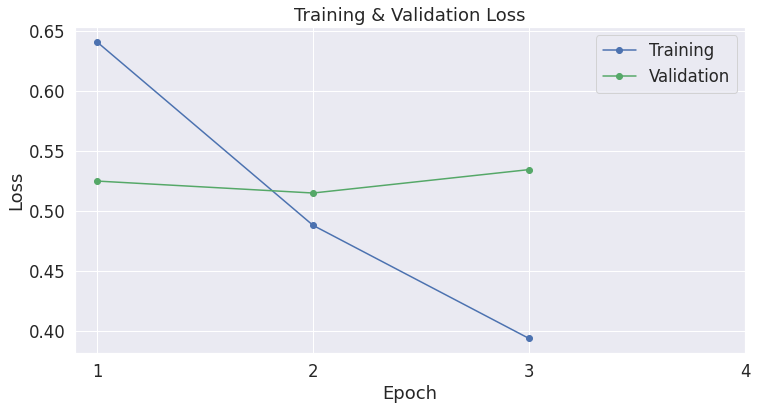

In [21]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# 绘图风格设置
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# 绘制学习曲线
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
import os

# 模型存储到的路径
output_dir = './model_save/'

# 目录不存在则创建
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# 使用 `save_pretrained()` 来保存已训练的模型，模型配置和分词器
# 它们后续可以通过 `from_pretrained()` 加载
model_to_save = model.module if hasattr(model, 'module') else model  # 考虑到分布式/并行（distributed/parallel）训练
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.txt',
 './model_save/added_tokens.json')